# RNN and CNN Text Text Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pprint
from sklearn.utils import shuffle

from tqdm.auto import tqdm
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from timeit import default_timer as timer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
pip install datasets torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "L

In [4]:
from torchinfo import summary

In [5]:
from datasets import load_dataset
ds = load_dataset("emotion")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [9]:
train = pd.DataFrame(ds['train'])
val = pd.DataFrame(ds['validation'])
test = pd.DataFrame(ds['test'])

In [10]:
X_train, X_test, y_train, y_test =  train['text'], test['text'], train['label'], test['label']

In [122]:
lens = [len(x.split()) for x in X_train]

In [123]:
np.average(lens)

np.float64(19.1663125)

In [11]:
X_train, X_val, y_train, y_val =  train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.1, random_state=42)

In [12]:
X_train, X_val, X_test, y_train, y_val, y_test =  train['text'], val['text'], test['text'], train['label'], val['label'], test['label']

In [13]:
for w in X_train[0].lower().split():
    print(w)

i
didnt
feel
humiliated


In [16]:
assert(len(y_test) == len(X_test))

In [17]:
pad_token = "PAD"
unk_token = "UNK"
pad_token_id = 0
unk_token_id = 1

In [160]:
def get_dictionary(corpus, unk_token=unk_token, pad_token=pad_token, word_count_threshold=2):
    dictionary = {}

    for sentence in corpus:
        for word in sentence.lower().split():
            if word in dictionary:
                dictionary[word] += 1
            else:
                dictionary[word] = 1

    words = [pad_token, unk_token] + \
        [w for w in sorted(dictionary) if dictionary[w] > word_count_threshold]

    word2id = {w: i for i, w in enumerate(words)}
    id2word  = {i: w for w, i in word2id.items()}
    return word2id, id2word

In [161]:
def get_vocab(texts, unk_token=unk_token, pad_token=pad_token):
    word2id = {pad_token : 0, unk_token : 1}
    index = 2

    for sentence in texts:
        for word in sentence.lower().split():
            if word2id.get(word, None) == None:
                word2id[word] = index
                index += 1

    id2word  = {v: k for k, v in word2id.items()}
    return word2id, id2word


In [162]:
def tokenize_texts(texts, word2id, unk_token_id=unk_token_id):
    result = []

    for sentence in texts:
        sentence_tokenized = []

        for word in sentence.lower().split():
            sentence_tokenized.append(word2id.get(word, unk_token_id))

        result.append(sentence_tokenized)

    return result

In [163]:
def decode_texts(tokens, id2word, unk_token=unk_token):
    result = []

    for sentence in tokens:
        sentence_decoded = []

        for word in sentence:
            sentence_decoded.append(id2word.get(word, unk_token))

        result.append(sentence_decoded)

    return result

In [164]:
word2id, id2word = get_dictionary(X_train)

In [165]:
len(word2id)

5260

In [166]:
VOCAB_SIZE = len(word2id)

In [167]:
text = tokenize_texts(X_train, word2id)[0]

In [168]:
len(text)

4

In [169]:
text

[2269, 1232, 1703, 2251]

In [170]:
decode_texts([text], id2word)

[['i', 'didnt', 'feel', 'humiliated']]

In [171]:
X_train_tokenized   = tokenize_texts(X_train, word2id)
X_val_tokenized     = tokenize_texts(X_val, word2id)
X_test_tokenized    = tokenize_texts(X_test, word2id)

## Data generator

#### The proper way to do this is to sort the batches in decending order and to use torch.nn.utils.rnn.pad_packed_sequence and torch.nn.utils.rnn.pack_padded_sequence and to sort each batch in reverse ordered by the length of each text

In [172]:
def data_generator(X, y, batch_size=32, shuffle_data=True, pad_token_id=pad_token_id):

    if shuffle_data:
        X, y = shuffle(X, y)

    n_batches = int(np.ceil(len(y) / batch_size))

    for batch in range(n_batches):
        end = min((batch + 1) * batch_size, len(y))

        X_batch = X[batch * batch_size:end]
        y_batch = y[batch * batch_size:end]

        max_len = np.max([len(x) for x in X_batch])
        for sample in range(len(X_batch)):
            x = X_batch[sample]
            pad = [pad_token_id] * (max_len - len(x))
            X_batch[sample] = pad + x

        X_batch = torch.from_numpy(np.array(X_batch)).long()
        y_batch = torch.from_numpy(np.array(y_batch)).long()

        yield X_batch, y_batch

In [173]:
train_gen   = lambda : data_generator(X_train_tokenized, y_train.tolist())
val_gen     = lambda : data_generator(X_val_tokenized  , y_val.tolist(), shuffle_data=False)
test_gen    = lambda : data_generator(X_test_tokenized , y_test.tolist(), shuffle_data=False)

In [174]:
def train_step(model, data_loader, loss_fn, optimizer, device):

    model.train()

    train_loss, train_acc = 0, 0
    steps = 0

    for X, y in data_loader():
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        steps += 1

    return train_loss / steps, train_acc / steps


def test_step(model, data_loader, loss_fn, device):

    model.eval()

    test_loss, test_acc = 0, 0
    steps = 0

    with torch.inference_mode():
        for X, y in data_loader():

            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            steps += 1

    return test_loss / steps, test_acc / steps

def train(model,
          train_data_loader,
          test_data_loader,
          optimizer,
          loss_fn,
          epochs,
          device):

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
        }

    model.to(device)

    for epoch in tqdm(range(epochs)):

        start_time = timer()
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_data_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )
        end_time = timer()

        test_loss, test_acc = test_step(
            model=model,
            data_loader=test_data_loader,
            loss_fn=loss_fn,
            device=device,
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"time: {(end_time-start_time):.4f}"
        )

    return results

def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def get_preds_and_true(model, data_loader, device):

    model.eval()


    y_preds = []
    y_true = []

    with torch.inference_mode():
        for X, y in data_loader():

            X = X.to(device)

            y_pred = model(X)

            y_pred = torch.softmax(y_pred, dim=1).argmax(dim=1)
            y_preds.append(y_pred.cpu())
            y_true.append(y.cpu())

    return torch.cat(y_preds), torch.cat(y_true)

## RNN

In [175]:
class RNN(nn.Module):
    def __init__(self, n_vocab, embed_dim, hidden_size, n_layers, n_outputs, bidirectional=False, dropout=0):
        super(RNN, self).__init__()
        self.n_vocab = n_vocab
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.out_dim = n_outputs
        self.bi = bidirectional

        self.embed = nn.Embedding(self.n_vocab, self.embed_dim)

        self.rnn = nn.LSTM(
            input_size=self.embed_dim,
            hidden_size=self.hidden_size,
            num_layers=self.n_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout
        )

        if self.bi:
            self.fc = nn.Linear(hidden_size * 2 , self.out_dim)
        else:
            self.fc = nn.Linear(hidden_size , self.out_dim)


    def forward(self, x):
        # x.shape [n_samples, max_seq_len]

        if self.bi:
            h0 = torch.zeros(self.n_layers * 2, x.size(0), self.hidden_size).to(device)
            c0 = torch.zeros(self.n_layers * 2, x.size(0), self.hidden_size).to(device)
        else:
            h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device)
            c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device)
        # h0.shape = c0.shape: [n_layers, n_samples, hidden_size]

        x = self.embed(x.to(torch.int64))
        # x.shape [n_samples, max_seq_len, embed_dim]
        x, (h_out, c_out) = self.rnn(x, (h0, c0))
        # x.shape [n_samples, max_seq_len, hidden_size]=

        x, _ = torch.max(x, 1)
        # x.shape [n_samples, hidden_size]

        x = self.fc(x)

        return x

In [176]:
rnn_model = RNN(n_vocab=VOCAB_SIZE, embed_dim=128, hidden_size=96, n_layers=3, n_outputs=6, bidirectional=True, dropout=0.5)

print(rnn_model)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=5e-4)

RNN(
  (embed): Embedding(5260, 128)
  (rnn): LSTM(128, 96, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=192, out_features=6, bias=True)
)


In [177]:
import torchinfo

In [ ]:
128, 256,

In [178]:
rnn2_model = RNN(n_vocab=VOCAB_SIZE, embed_dim=128, hidden_size=96, n_layers=1, n_outputs=6, bidirectional=True, dropout=0.5)
torchinfo.summary(rnn2_model, (1 , 64))

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [1, 6]                    --
├─Embedding: 1-1                         [1, 64, 128]              673,280
├─LSTM: 1-2                              [1, 64, 192]              173,568
├─Linear: 1-3                            [1, 6]                    1,158
Total params: 848,006
Trainable params: 848,006
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 11.78
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 3.39
Estimated Total Size (MB): 3.56

In [179]:
5260 * 128

673280

In [180]:
96*2

192

In [181]:
128+96

224

In [182]:
96*2

192

In [183]:
224*192*4 *2

344064

In [184]:
torchinfo.summary(rnn_model, (1 , 64))

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [1, 6]                    --
├─Embedding: 1-1                         [1, 64, 128]              673,280
├─LSTM: 1-2                              [1, 64, 192]              619,008
├─Linear: 1-3                            [1, 6]                    1,158
Total params: 1,293,446
Trainable params: 1,293,446
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 40.29
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 5.17
Estimated Total Size (MB): 5.34

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5383 | train_acc: 37.4438 | test_loss: 1.3625 | test_acc: 49.4048 | time: 3.2606
Epoch: 2 | train_loss: 1.1237 | train_acc: 57.1125 | test_loss: 0.8586 | test_acc: 65.4266 | time: 3.8265
Epoch: 3 | train_loss: 0.6813 | train_acc: 73.0563 | test_loss: 0.5621 | test_acc: 79.1171 | time: 5.4304
Epoch: 4 | train_loss: 0.3877 | train_acc: 86.2062 | test_loss: 0.3603 | test_acc: 87.2520 | time: 5.9327
Epoch: 5 | train_loss: 0.2364 | train_acc: 91.6063 | test_loss: 0.3044 | test_acc: 89.3849 | time: 5.3516
Epoch: 6 | train_loss: 0.1614 | train_acc: 93.8812 | test_loss: 0.2782 | test_acc: 89.7817 | time: 3.2936
Epoch: 7 | train_loss: 0.1246 | train_acc: 95.3500 | test_loss: 0.3052 | test_acc: 89.8810 | time: 3.8896
Epoch: 8 | train_loss: 0.0981 | train_acc: 96.2750 | test_loss: 0.2958 | test_acc: 90.3770 | time: 5.6561
Epoch: 9 | train_loss: 0.0811 | train_acc: 96.9875 | test_loss: 0.2789 | test_acc: 90.9722 | time: 4.4050
Epoch: 10 | train_loss: 0.0675 | train_acc: 97

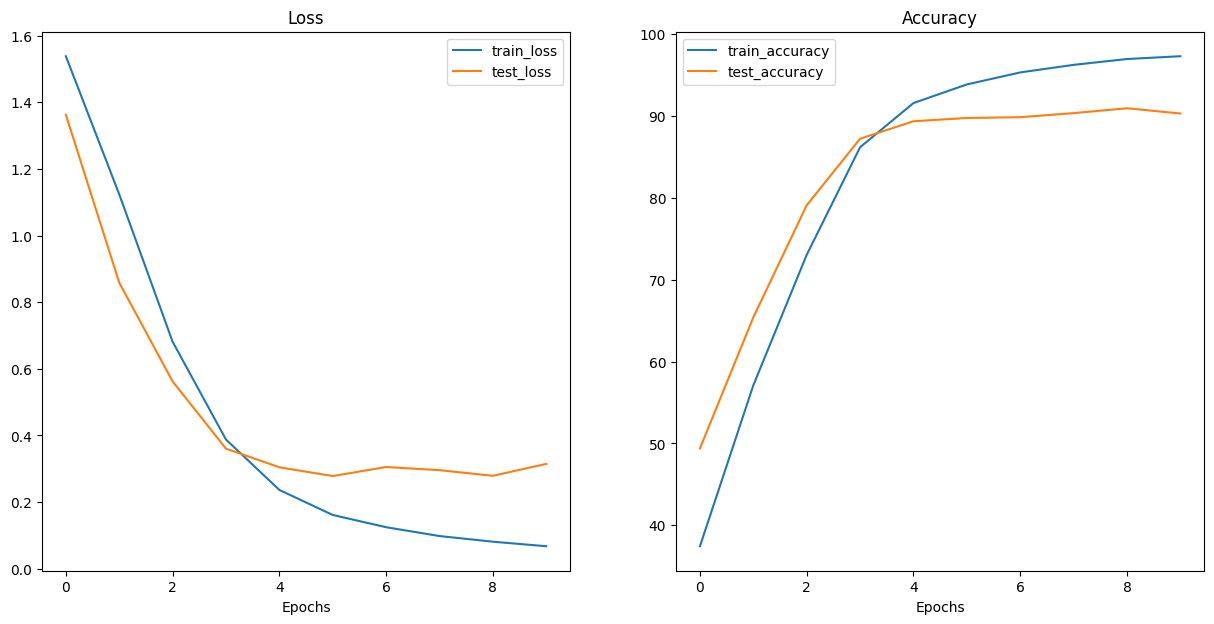

In [185]:
results = train(model=rnn_model,
          train_data_loader = train_gen,
          test_data_loader = val_gen,
          optimizer = optimizer,
          loss_fn = loss,
          epochs = 10,
          device = device)

plot_loss_curves(results)

## CNN

In [190]:
class CNN(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_outputs):
        super(CNN, self).__init__()
        self.n_vocab = n_vocab
        self.embed_dim = embed_dim
        self.out_dim = n_outputs

        self.embed = nn.Embedding(self.n_vocab, self.embed_dim)

        self.conv1 = nn.Conv1d(in_channels=self.embed_dim,\
                               out_channels=32, kernel_size=5, padding='same')
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 32, 3, padding='same')

        self.fc = nn.Linear(32, self.out_dim)

    def forward(self, text):
        # x.shape [n_samples, max_seq_len]
        X = self.embed(text.to(torch.int64))
        # x.shape [n_samples, max_seq_len, embed_dim]
        X = X.permute(0, 2, 1)
        # x.shape [n_samples, embed_dim, max_seq_len]

        X = self.conv1(X)
        # x.shape [n_samples, out_channels, max_seq_len]
        X = F.relu(X)
        X = self.pool1(X)
        # x.shape [n_samples, out_channels, max_seq_len / 2]

        X = self.conv2(X)
        # x.shape [n_samples, out_channels, max_seq_len / 2]
        X = F.relu(X)

        X = X.permute(0, 2, 1)
        # x.shape [n_samples, max_seq_len / 2, out_channels]
        X, _ = torch.max(X, 1)

        X = self.fc(X)
        return X


In [191]:
cnn_model = CNN(VOCAB_SIZE, 64, 6)
print(cnn_model)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=75e-5, weight_decay=1e-4)

CNN(
  (embed): Embedding(5260, 64)
  (conv1): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=same)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=same)
  (fc): Linear(in_features=32, out_features=6, bias=True)
)


In [192]:
torchinfo.summary(cnn_model, (1 , 64,))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 6]                    --
├─Embedding: 1-1                         [1, 64, 64]               336,640
├─Conv1d: 1-2                            [1, 32, 64]               10,272
├─MaxPool1d: 1-3                         [1, 32, 32]               --
├─Conv1d: 1-4                            [1, 32, 32]               3,104
├─Linear: 1-5                            [1, 6]                    198
Total params: 350,214
Trainable params: 350,214
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.09
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 1.40
Estimated Total Size (MB): 1.46

In [193]:
results = train(model=cnn_model,
          train_data_loader = train_gen,
          test_data_loader = val_gen,
          optimizer = optimizer,
          loss_fn = loss,
          epochs = 10,
          device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5572 | train_acc: 36.7250 | test_loss: 1.5092 | test_acc: 41.8155 | time: 2.0826
Epoch: 2 | train_loss: 1.3225 | train_acc: 50.8250 | test_loss: 1.1406 | test_acc: 57.7381 | time: 1.8429
Epoch: 3 | train_loss: 0.8614 | train_acc: 69.7562 | test_loss: 0.7103 | test_acc: 75.1984 | time: 1.8502
Epoch: 4 | train_loss: 0.4760 | train_acc: 83.5500 | test_loss: 0.4204 | test_acc: 85.4167 | time: 1.8694
Epoch: 5 | train_loss: 0.2617 | train_acc: 90.5875 | test_loss: 0.3104 | test_acc: 88.7401 | time: 1.8438
Epoch: 6 | train_loss: 0.1786 | train_acc: 93.5125 | test_loss: 0.2550 | test_acc: 90.6250 | time: 1.9631
Epoch: 7 | train_loss: 0.1368 | train_acc: 94.8375 | test_loss: 0.2493 | test_acc: 91.4187 | time: 2.7743
Epoch: 8 | train_loss: 0.1131 | train_acc: 95.6625 | test_loss: 0.2393 | test_acc: 91.3690 | time: 1.8378
Epoch: 9 | train_loss: 0.0961 | train_acc: 96.5187 | test_loss: 0.2315 | test_acc: 91.4187 | time: 1.8476
Epoch: 10 | train_loss: 0.0825 | train_acc: 96

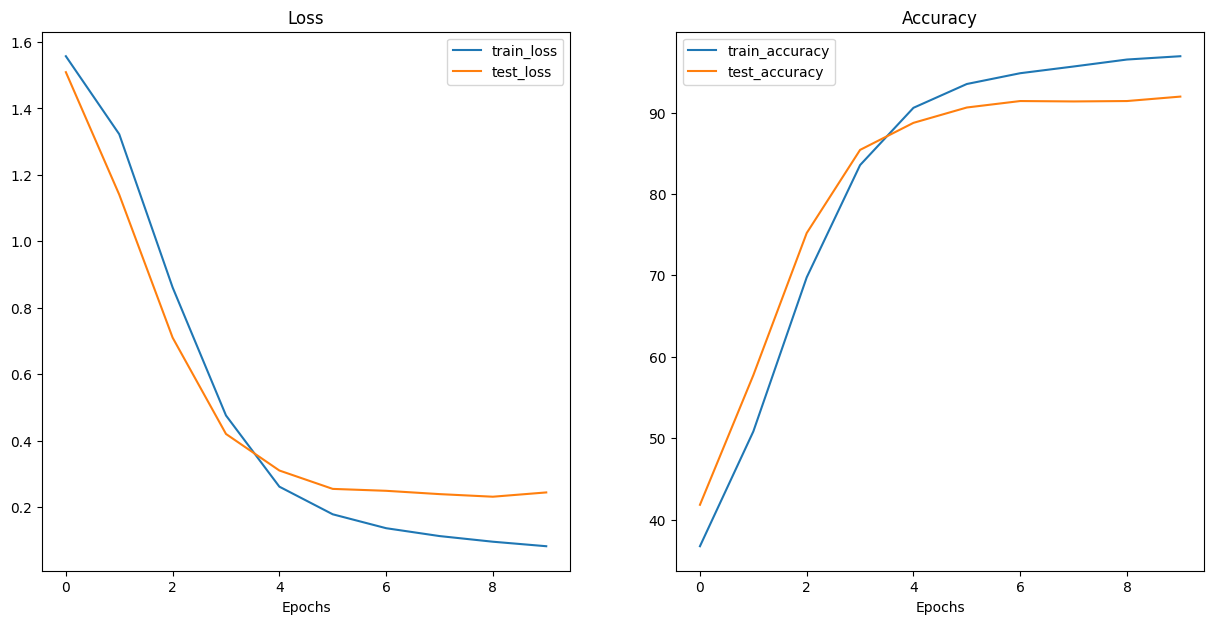

In [194]:
plot_loss_curves(results)

## Testing

In [109]:
y_preds, y_true = get_preds_and_true(cnn_model, test_gen, device)

In [110]:
labels = ["sadness", "joy", "love", "fear", "surprise", "anger"]

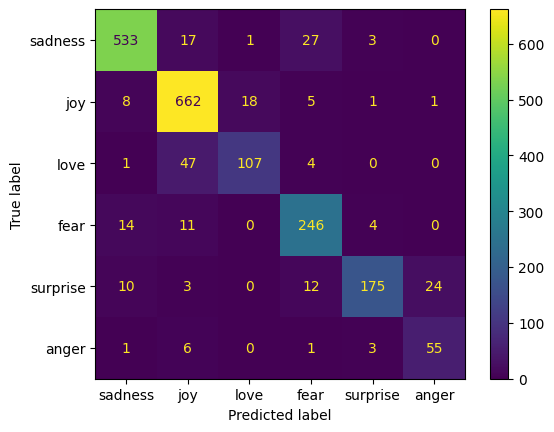

In [111]:
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()

In [112]:
y_preds, y_true = np.array(y_preds.cpu()), np.array(y_true.cpu())

In [113]:
test_texts = pd.DataFrame(ds['test'])['text']

In [114]:
miss_classifications = pd.DataFrame(
    {
    'text' : list(test_texts[y_true != y_preds]),
    'true label' : y_true[y_true != y_preds],
    'predicted label' : y_preds[y_true != y_preds]
    })

In [115]:
pp = pprint.PrettyPrinter()

In [116]:
def print_miss_classifications(df):
    index = random.choice(miss_classifications.index)
    pp.pprint(miss_classifications.loc[index].text)
    print(f"True label ", labels[miss_classifications.loc[index]['true label']])
    print("Predicted  label ", labels[miss_classifications.loc[index]['predicted label']])

In [117]:
print_miss_classifications(miss_classifications)

'i began to feel very strange'
True label  surprise
Predicted  label  anger


In [118]:
print_miss_classifications(miss_classifications)

'i just can t feel accepted'
True label  love
Predicted  label  joy


In [119]:
print_miss_classifications(miss_classifications)

'i still feel a little weird and uncertain'
True label  surprise
Predicted  label  anger
